In my previous notebooks, I run `tractor` in an iterative way: add several sources each time and have the model optimized. But I noticed that in the `legacypipe`, Dustin Lang runs `tractor` on a [blob-by-blob basis](https://github.com/legacysurvey/legacypipe/blob/main/doc/outline.md#fitting): in order of brightness.

https://www.legacysurvey.org/dr9/catalogs/#id9

[Might not be related to this notebook]: Model selection when there is no DECaLS tractor catalog: https://github.com/legacysurvey/legacypipe/blob/main/doc/outline.md#model-selection, https://github.com/legacysurvey/legacypipe/blob/6d1a92f8462f4db9360fb1a68ef7d6c252781027/py/legacypipe/oneblob.py#L605

In [4]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

import pickle
from IPython.display import clear_output

import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from kuaizi import HSC_zeropoint, HSC_pixel_scale

In [3]:
## Load catalog and images
obj_cat = Table.read('/Users/jiaxuanli/Research/Merian/cosmos_test_1/cosmos_test_1-2021-02-04.fits')

In [5]:
obj_cat

<Table length=10>
       name        ...  radius
                   ...  arcsec
     bytes18       ... float64
------------------ ... -------
s18a_wide_226984_y ...    15.0
s18a_wide_233677_y ...    15.0
s18a_wide_238189_y ...    15.0
s18a_wide_240617_y ...    15.0
s18a_wide_255782_y ...    15.0
s18a_wide_265172_y ...    15.0
s18a_wide_274464_y ...    15.0
s18a_wide_275931_y ...    15.0
s18a_wide_277061_y ...    15.0
s18a_wide_301016_y ...    15.0

In [7]:
# import scarlet # I only use this package to generate RGB image for display purpose.
# ## Initialize `unagi`
# from unagi import hsc, config
# from unagi import plotting
# from unagi import task, catalog

# pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

## Let's fit a dwarf step by step

In [8]:
channels = 'grizy'

obj = obj_cat[0]
obj_id = obj['name'].lstrip('s18a_wide').rstrip('_y')

cutout = [
    fits.open(
        f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}.fits'
    ) for filt in channels
]
psf_list = [
    fits.open(
        f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}_psf.fits'
    ) for filt in channels
]

coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

In [9]:
# Reconstruct data
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

images = np.array([hdu[1].data for hdu in cutout])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = list(channels)
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
# `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy

(-0.5, 178.5, -0.5, 178.5)

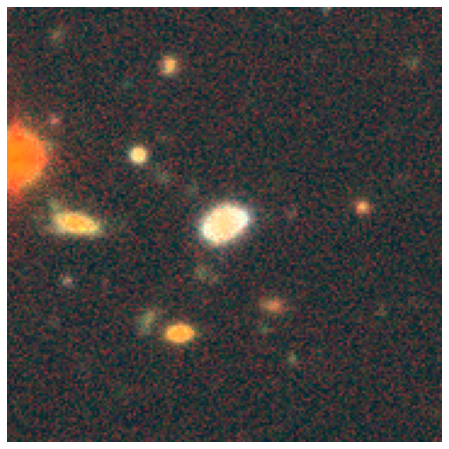

In [10]:
# Visualize our data, optional
import scarlet

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(len(channels))

img_rgb = scarlet.display.img_to_rgb(
    data.images,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(img_rgb, origin='lower')
plt.axis('off')

In [11]:
## Use Source Extractor to deblend and initialize `tractor`
from kuaizi.tractor.utils import makeCatalog

filt = 'i'
layer_ind = channels.index(filt)

    Detected 18 objects


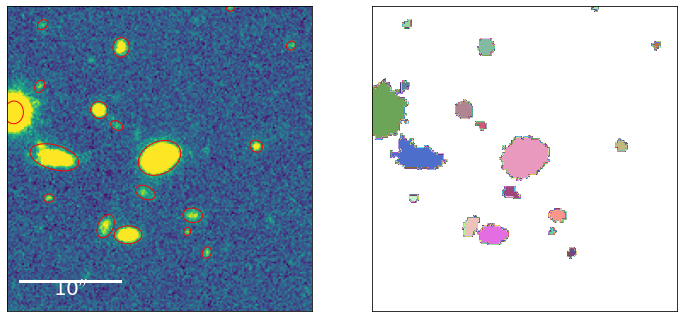

In [12]:
# typical Source Extractor Python (SEP) run, with relatively-low sigma
obj_cat_sep, segmap_sep = makeCatalog(
    [data],
    layer_ind=layer_ind,
    lvl=2.0, # 2.5
    mask=None,
    method='vanilla',
    convolve=False, 
    match_gaia=False,
    show_fig=True,
    visual_gaia=False,
    b=32,
    f=3,
    pixel_scale=0.168,
    minarea=5,
    deblend_nthresh=48,
    deblend_cont=0.005,
    sky_subtract=True)

In [13]:
from kuaizi import HSC_pixel_scale
obj_cat_sep['a_arcsec'] = obj_cat_sep['a'] * HSC_pixel_scale
obj_cat_sep['b_arcsec'] = obj_cat_sep['b'] * HSC_pixel_scale
obj_cat_sep['type'] = np.repeat(b'NAN', len(obj_cat_sep))

obj_cat_sep.sort('flux', reverse=True)
obj_cat_sep

<Table length=18>
obj_type index         x          ...       b_arcsec       type 
 object  int64      float64       ...       float64       bytes3
-------- ----- ------------------ ... ------------------- ------
    None     0 3.3699276950116546 ...  0.3791554870605469    NAN
    None     1  89.04483565402633 ...  0.6327950706481934    NAN
    None     2 27.213546788628516 ...  0.4815539588928223    NAN
    None     3  70.56485832996246 ... 0.35415181732177736    NAN
    None     4  53.58504781931923 ...  0.3261882133483887    NAN
    None     5  66.48149540113882 ... 0.32411554241180424    NAN
    None     6 57.410207516433815 ...  0.3016087989807129    NAN
    None     7 108.56933538812041 ...  0.2869972429275513    NAN
    None     8  145.9186962244493 ... 0.22922168827056885    NAN
    None     9  80.77024323342474 ...   0.254388599395752    NAN
    None    10  18.60783684800493 ... 0.18159341526031494    NAN
    None    11 116.88270170857591 ... 0.17628341388702393    NAN
    None    12  24.01499959982193 ...  0.1619959373474121    NAN
    None    13 63.877831144398044 ... 0.16876551818847657    NAN
    None    14  20.26821902636071 ... 0.17090988636016846    NAN
    None    15  166.4706481292195 ... 0.17091429233551025    NAN
    None    16  105.3471325443954 ...  0.1317616539001465    NAN
    None    17  130.7501888118724 ...  0.1075905032157898    NAN

In [14]:
### We don't need DECaLS catalog anymore
catalog_c = SkyCoord(obj_cat_sep['ra'], obj_cat_sep['dec'], unit='deg')
dist = coord.separation(catalog_c)
cen_obj_ind = np.argsort(dist)[0]
cen_obj = obj_cat_sep[cen_obj_ind]
### Add a "target" column to indicate which object is the target galaxy ###
obj_cat_sep['target'] = np.zeros(len(obj_cat_sep), dtype=int)
obj_cat_sep['target'][cen_obj_ind] = 1

#print(f'# Type of central object is {cen_obj["type"]}')
print(f'# Total number of objects: {len(obj_cat_sep)}')

# Total number of objects: 18


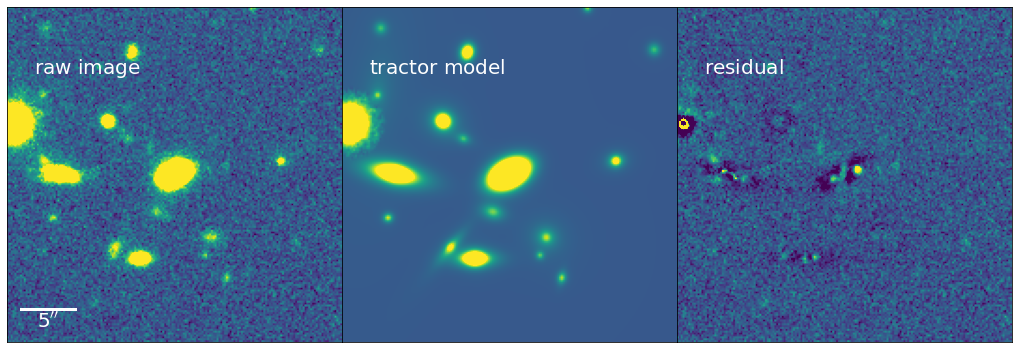

   The chi-square is 49943.07


In [15]:
from tractor import PixelizedPSF
from kuaizi.tractor.utils import tractor_blob_by_blob
psf_obj = PixelizedPSF(data.psfs[layer_ind]) # Construct PSF

sources, trac_obj, fig = tractor_blob_by_blob(
    obj_cat_sep,
    data.wcs,
    data.images[layer_ind],
    data.weights[layer_ind],
    psf_obj,
    kuaizi.HSC_pixel_scale,
    shape_method='manual',
    freeze_dict={'pos': False, 'shape': False, 'sersicindex': False},
    fig_name='test')
trac_obj.target_ind = cen_obj_ind

### make catalog output

In [18]:
from kuaizi.tractor.utils import getTargetProperty

In [19]:
source_output = getTargetProperty(trac_obj, wcs=data.wcs)

In [20]:
source_output

{'x': 88.78825452486984,
 'y': 89.36464976057651,
 'flux': 6.547283117255933,
 're': 1.0462537063676498,
 'ab': 0.5482416828626303,
 'phi': 117.06452774925557,
 'sersic': 0.7612725462543254,
 'x_ivar': 5160.14892578125,
 'y_ivar': 10818.8271484375,
 'flux_ivar': 5649.4564640353765,
 're_ivar': 71323.5390625,
 'ab_ivar': 66821.78125,
 'phi_ivar': 15.417464256286621,
 'sersic_ivar': 14645.82421875,
 'type': 'SER',
 'ra': 149.60127506757723,
 'dec': 1.6225282659310563,
 'ra_ivar': 2370406532094.7065,
 'dec_ivar': 4967828792649.871}

## Run forced-photometry in all bands

In [21]:
from kuaizi.tractor.utils import tractor_hsc_sep_blob_by_blob

In [22]:
## Load catalog and images
obj_cat = Table.read('/Users/jiaxuanli/Research/Merian/cosmos_test_1/cosmos_test_1-2021-02-04.fits')
obj = obj_cat[0]

obj_name = obj['name'].rstrip('_y')
obj_id = obj_name.lstrip('s18a_wide')

coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

cutout = [
    fits.open(
        f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}.fits'
    ) for filt in channels
]
psf_list = [
    fits.open(
        f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}_psf.fits'
    ) for filt in channels
]

# Reconstruct data
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

images = np.array([hdu[1].data for hdu in cutout])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = list(channels)
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)

### `s18a_wide_226984` i-band
    Detected 18 objects
# Total number of objects: 18
# Central object index in i-band: 1


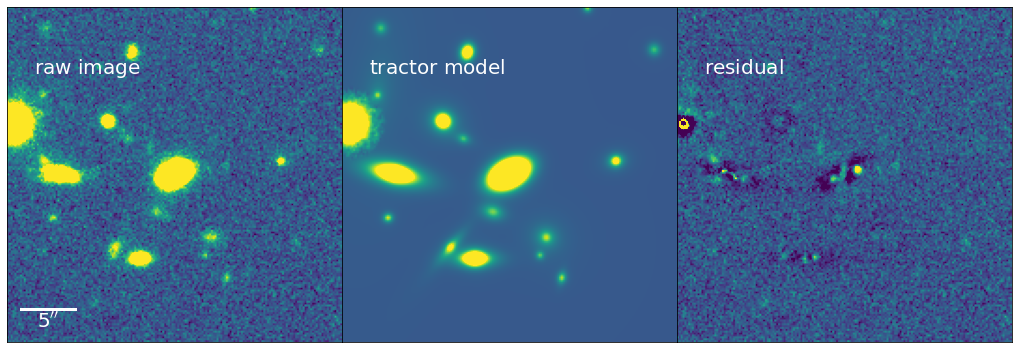

   The chi-square is 49943.07
SersicGalaxy at pixel (88.79, 89.36) with Flux: 413.106 and Galaxy Shape: re=1.05, ab=0.55, phi=117.1, Sersic index 0.761
### `s18a_wide_226984` g-band
    Detected 12 objects
# Total number of objects: 12
# Central object index in g-band: 1


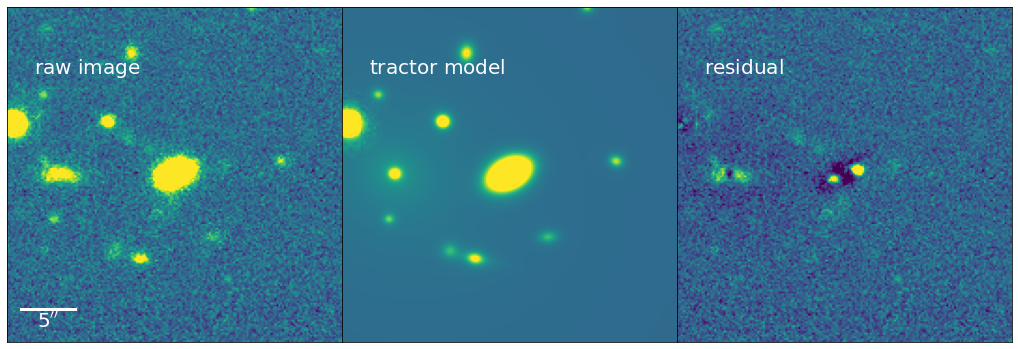

   The chi-square is 40085.31
SersicGalaxy at pixel (88.79, 89.36) with Flux: 282.462 and Galaxy Shape: re=1.05, ab=0.55, phi=117.1, Sersic index 0.761
### `s18a_wide_226984` r-band
    Detected 16 objects
# Total number of objects: 16
# Central object index in r-band: 1


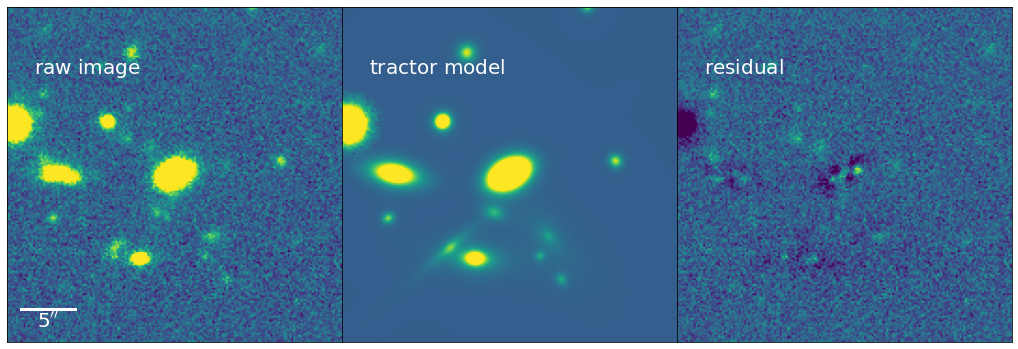

   The chi-square is 79298.88
SersicGalaxy at pixel (88.79, 89.36) with Flux: 343.874 and Galaxy Shape: re=1.05, ab=0.55, phi=117.1, Sersic index 0.761
### `s18a_wide_226984` z-band
    Detected 11 objects
# Total number of objects: 11
# Central object index in z-band: 1


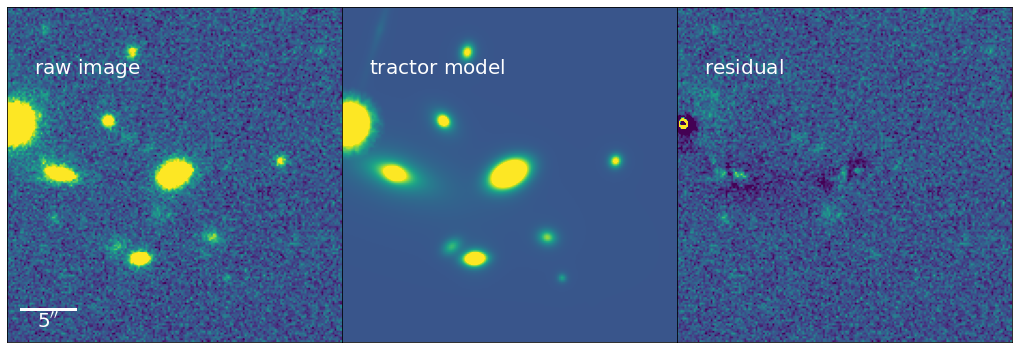

   The chi-square is 45802.043
SersicGalaxy at pixel (88.79, 89.36) with Flux: 428.727 and Galaxy Shape: re=1.05, ab=0.55, phi=117.1, Sersic index 0.761
### `s18a_wide_226984` y-band
    Detected 8 objects
# Total number of objects: 8
# Central object index in y-band: 1


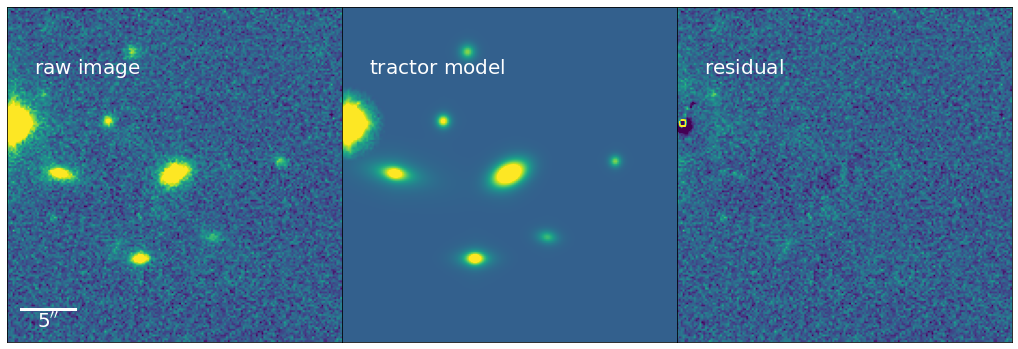

   The chi-square is 44068.07
SersicGalaxy at pixel (88.79, 89.36) with Flux: 476.037 and Galaxy Shape: re=1.05, ab=0.55, phi=117.1, Sersic index 0.761


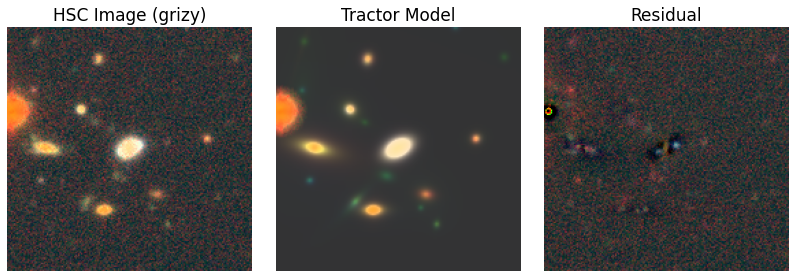

In [23]:
channels = 'grizy'
forced_channels = 'grzy'

for obj in obj_cat[0:1]:
    obj_name = obj['name'].rstrip('_y')
    obj_id = obj_name.lstrip('s18a_wide')
    
    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    cutout = [
        fits.open(
            f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}.fits'
        ) for filt in channels
    ]
    psf_list = [
        fits.open(
            f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}_psf.fits'
        ) for filt in channels
    ]

    # Reconstruct data
    from kuaizi.detection import Data
    from kuaizi.utils import padding_PSF

    images = np.array([hdu[1].data for hdu in cutout])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    filters = list(channels)
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
    data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
    # `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy
    
    
    # Start fitting
    # fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands
    model_dict = {}
    
    ref_filt = 'i'
    model_dict[ref_filt] = tractor_hsc_sep_blob_by_blob(
        obj, ref_filt, channels, data, 
        freeze_dict={'pos': False, 'shape': False, 'sersicindex': False}, # don't fix shape/sersic
        verbose=False)

    for filt in forced_channels:
        model_dict[filt] = tractor_hsc_sep_blob_by_blob(
            obj, filt, channels, data, 
            ref_source=model_dict[ref_filt].catalog[model_dict[ref_filt].target_ind],
            freeze_dict={'pos': True, 'shape': True, 'sersicindex': True}, # don't fix shape/sersic
            verbose=False)
    
    with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
        pickle.dump(model_dict, f)
    
    ### Make figures into a PDF file (slow)
    from fpdf import FPDF
    pdf = FPDF()
    pdf.add_page()
    for k, image in enumerate([obj_name + '_sep_tractor_' + filt + '.png' for filt in channels]):
        pdf.image(image, 21, 11 + k * 55, 167, 55)
    pdf.output(obj_name + "_sep_tractor.pdf", "F")

    # Visualize our model
    from kuaizi.tractor.utils import HiddenPrints
    with HiddenPrints():
        model_img = np.asarray([model_dict[key].getModelImage(0) for key in channels])

    stretch = 1
    Q = 0.5
    channel_map = scarlet.display.channels_to_rgb(len(channels))

    img_rgb = scarlet.display.img_to_rgb(
        data.images,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)

    model_rgb = scarlet.display.img_to_rgb(
        model_img,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)

    res_rgb = scarlet.display.img_to_rgb(
        data.images - model_img,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)

    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 8))
    ax1.imshow(img_rgb, origin='lower')
    ax2.imshow(model_rgb, origin='lower')
    ax3.imshow(res_rgb, origin='lower')

    for ax in [ax1, ax2, ax3]:
        ax.axis('off')

    ax1.set_title('HSC Image (grizy)', fontsize=17)
    ax2.set_title('Tractor Model', fontsize=17)
    ax3.set_title('Residual', fontsize=17)

    plt.subplots_adjust(wspace=0.1)
    plt.savefig(obj_name + '_sep_tractor_rgb.png', 
                bbox_inches='tight', 
                metadata={'Comment': 'Each filter is fit seperately, using the Source Extractor + DECaLS catalog in each filter'})
    

    #clear_output()
    #plt.close()

In [24]:
properties = {}

for filt in channels:
    properties[filt] = getTargetProperty(model_dict[filt], wcs=data.wcs)
    
catalog = {}
for key in [
        'ra', 'dec', 'x', 'y', 'flux', 're', 'ab', 'phi', 'sersic', 'type',
        'ra_ivar', 'dec_ivar', 'x_ivar', 'y_ivar', 'flux_ivar', 're_ivar',
        'ab_ivar', 'phi_ivar', 'sersic_ivar'
]:
    catalog[f'{key}'] = np.array([properties[filt][key] for filt in channels])

In [25]:
catalog

{'ra': array([149.60127507, 149.60127507, 149.60127507, 149.60127507,
        149.60127507]),
 'dec': array([1.62252827, 1.62252827, 1.62252827, 1.62252827, 1.62252827]),
 'x': array([88.78825452, 88.78825452, 88.78825452, 88.78825452, 88.78825452]),
 'y': array([89.36464976, 89.36464976, 89.36464976, 89.36464976, 89.36464976]),
 'flux': array([4.47672293, 5.45003099, 6.54728312, 6.79485937, 7.54468434]),
 're': array([1.04625371, 1.04625371, 1.04625371, 1.04625371, 1.04625371]),
 'ab': array([0.54824168, 0.54824168, 0.54824168, 0.54824168, 0.54824168]),
 'phi': array([117.06452775, 117.06452775, 117.06452775, 117.06452775,
        117.06452775]),
 'sersic': array([0.76127255, 0.76127255, 0.76127255, 0.76127255, 0.76127255]),
 'type': array(['SER', 'SER', 'SER', 'SER', 'SER'], dtype='<U3'),
 'ra_ivar': array([1.33389344e+12, 1.32292614e+12, 2.37040653e+12, 6.54514573e+11,
        1.95831847e+11]),
 'dec_ivar': array([2.86262837e+12, 2.71110807e+12, 4.96782879e+12, 1.36301431e+12,
     